In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from surprise import SVD
from surprise import Dataset

# # Load the movielens-100k dataset (download it if needed).
# data = Dataset.load_builtin('ml-100k')

# # Use the famous SVD algorithm.
# algo = SVD()

# # Run 5-fold cross-validation and print results.
# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


In [ ]:
import pandas as pd
from surprise import BaselineOnly
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate

In [ ]:
from surprise.dataset import DatasetAutoFolds

In [ ]:
from surprise import KNNBasic

# Toy example

In [ ]:
bsl_options = { 'method': 'sgd' }
sim_options = { 'name': 'cosine' }

algo2 = BaselineOnly(bsl_options=bsl_options )
algo =SVD()

In [ ]:
# Creation of the dataframe. Column names are irrelevant.
ratings_dict = {'itemID': [1, 1, 1, 2, 2],
                'userID': [9, 32, 2, 45, 'user_foo'],
                'rating': [0, 0, 1, 0, 1]}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

# The columns must correspond to user id, item id and ratings (in that order).
surprised_dataset = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

# We can now use this dataset as we please, e.g. calling cross_validate
#cross_validate(algo, data, cv=2)

In [ ]:
surprised_trainset= DatasetAutoFolds.build_full_trainset(surprised_dataset)
fitted_trainset = algo2.fit(surprised_trainset)


In [ ]:
for rows, columns in df.iterrows():
    uid = str(columns['userID'])  # raw user id (as in the ratings file). They are **strings**!
    iid = str(columns['itemID'])  # raw item id (as in the ratings file). They are **strings**!
    r_ui = columns['rating']   # raw rating/purchase Don't use string! **NO strings**!

    # get a prediction for specific users and items.
    pred = fitted_trainset.predict(uid=uid, iid=iid, r_ui=r_ui, verbose=True)
    print(pred)

# Instacart

In [84]:
import pyodbc

driver= '{ODBC Driver 13 for SQL Server}'
cnxn = pyodbc.connect('DRIVER='+driver+';PORT=1433;SERVER='+\
                      server+';PORT=1443;DATABASE='+database+';UID='+username+';PWD='+ password)

In [86]:
data = pd.read_sql_query("""

with train_crossjoin as (
SELECT q.[user_id] as userID
, q.product_id as itemID 
, q.[order_id] , rating = 1
FROM [dbo].[order_products__All] as q
where q.[user_id] <=1000
and q.order_number = 3
)
select v.*, isnull(l.rating,0) as rating
from (
SELECT * --, a.itemID--, v.rating
FROM (select distinct userID 
from train_crossjoin) a
CROSS JOIN 
(select distinct itemID 
from train_crossjoin) as b
) as v
left join train_crossjoin l on l.itemID=v.itemID and l.userID=v.userID

""",cnxn, coerce_float = True)

In [87]:
data.head()

,userID,itemID,rating
0,1,1,0
1,10,1,0
2,100,1,0
3,1000,1,0
4,101,1,0


In [88]:
testdata = pd.read_sql_query("""

with train_crossjoin as (
SELECT q.[user_id] as userID
, q.product_id as itemID 
, q.[order_id] , rating = 1
FROM [dbo].[order_products__All] as q
where q.[user_id] <=1000
and q.order_number = 3
)
select v.*, isnull(l.rating,0) as rating
from (
SELECT * --, a.itemID--, v.rating
FROM (select distinct userID 
from train_crossjoin) a
CROSS JOIN 
(select distinct itemID 
from train_crossjoin) as b
) as v
left join (
select userID,itemID, rating = 1
from (
select  f.[user_id] as userID
, f.product_id as itemID 
, f.[order_id] 
, cast(f.order_number as int) as order_number
, rating =1
, DENSE_RANK() over(partition by f.[user_id] order by f.product_id asc ) as [row1]
from [dbo].[order_products__All] f
where --exists (select 1 from traindata t2 where t2.userID=f.[user_id])
 [user_id] <=1000
and order_number>3
--not exists (select 1 from traindata tt where tt.[order_id]=f.order_id)
) testset
where [row1] <=10
group by userID,itemID 
) as l on l.itemID=v.itemID and l.userID=v.userID

""",cnxn, coerce_float = True)

In [ ]:
bsl_options = { 'method': 'sgd' }
sim_options = { 'name': 'cosine' }

#algo = KNNBasic(sim_options=sim_options)
#algo = BaselineOnly(bsl_options=bsl_options )
algo =SVD()
reader = Reader(rating_scale=(0, 1))
surprised_dataset = Dataset.load_from_df(data[['userID', 'itemID', 'rating']], reader)
surprised_trainset= DatasetAutoFolds.build_full_trainset(surprised_dataset)
fitted_trainset = algo.fit(surprised_trainset)

In [ ]:
# Train the algorithm on the trainset, and predict ratings for the testset
#algo.fit(surprised_trainset)
predictions = []
for rows, columns in testdata.iterrows():
    uid = str(columns['userID'])  # raw user id (as in the ratings file). They are **strings**!
    iid = str(columns['itemID'])  # raw item id (as in the ratings file). They are **strings**!
    r_ui = columns['rating']   # raw rating/purchase Don't use string! **NO strings**!

    # get a prediction for specific users and items.
    pred = fitted_trainset.predict(uid=uid, iid=iid, r_ui=r_ui, verbose=False)
    predictions.append(pred)

# Then compute RMSE
#accuracy.rmse(predictions)

In [ ]:
fitted_trainset.predict(uid='112108', iid='39612', r_ui=0, verbose=False)

In [ ]:
fitted_trainset.predict(uid='79431', iid='47209', r_ui=0, verbose=False)

In [ ]:
predictions[:10]

# Model evaluation

In [97]:
from collections import defaultdict

from surprise import Dataset
from surprise import SVD
from surprise.model_selection import KFold


def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


# one shot evaluation

In [98]:
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=0.0312)

# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.0878
0.109755952381


# KFold (this takes a long time)

In [ ]:
kf = KFold(n_splits=5)

for trainset, testset in kf.split(surprised_dataset):
    algo2.fit(trainset)
    predictions1 = algo2.test(testset)
    precisions, recalls = precision_recall_at_k(predictions1, k=5, threshold=0.0312)

    # Precision and recall can then be averaged over all users
    print(sum(prec for prec in precisions.values()) / len(precisions))
    print(sum(rec for rec in recalls.values()) / len(recalls))

In [99]:
y_score = [v[3] for v in predictions ]
y_test = [v[2] for v in predictions ]

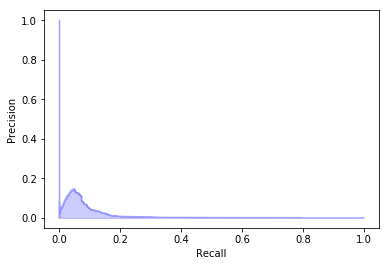

In [105]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

precision, recall, thresholds = precision_recall_curve(y_test, probas_pred = y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
#plt.ylim([0.0, 1.05])
#plt.xlim([0.0, 1.0])
#plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
#          average_precision))

# THE END

In [30]:
len (predictions)

1300769

In [31]:
len(testdata)

1300769

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
ratings_dict = {'itemID': [1, 1, 1, 2, 2],
                'userID': [9, 32, 2, 45, 'user_foo'],
                'rating': [0, 0, 1, 0, 1]}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 1))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [ ]:
DatasetAutoFolds.build_full_trainset(data)

In [ ]:
type(trainset1)

In [89]:
# from surprise.model_selection import train_test_split
# from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# sample random trainset and testset
# test set is made of 25% of the ratings.
#train, test = train_test_split(data1, test_size=.20)



Estimating biases using sgd...
